# CLASSIFICATION OF R/SOURDOUGH POSTS PER FLAIR TAGS: 02 - NAIVE BAYES CLASSIFIER

## 1) Introduction

### 1.1) General presentation: 

The aim of this project is to help predict the category of a post on the r/sourdough subreddit, based on its text content: its title, the content of the post itself and of the comments. More details on the general context of the project are provided in the first notebook : [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

The main strategy employed for the preprocessing of the data was a Bag-of-words approach, where the cleaning (cleaning, removing punctuation, numbers and  urls, lemmatization) and tokenization (splitting of the strings in smaller units; here words) was followed by counting each unique words to define the vocabulary. Then, each word was represented by its freqency in each post, pondered by its freqency in the whole corpus. The TF-IDF vectorizer was tuned to remove the noise(i.e.: words too frequent as well as words not frequent enough). 

In addition, posts categories were explored, and it was decided to regroup them in meta categories, as the large number of initial categories (40), paired with the large imbalance (some categories only having 1 observation, when others had  almost a thousand) would have lead to poor performance for the classifiers. 

Thus, the preprocessing resulted in two dataset: 
* A training set with 6713 observations and 1195 features that will be used to train our machine learning models through cross validation
* A test set with 2878 observations and 1195 features that will be used to test the performance of our models. 

The meta classes to predict, constructed based on insider knowledge of the r/sourdough subreddit are as follows: 
* Critique
* Discussion
* Help
* Look 

The Machine learning strategy for the project is as follows: 
1. Train multiple classifiers on the training set, using cross validation to tune the hyperparameters. These models, referred to as 0-level classifiers,  are: 
* Naive Bayes
* Logistic Regression
* K nearest neighbors
* Decision Tree
* Random Forest
* Support Vector Machine with a non linear kernel

2. Produce 5-folds out of bag predictions on the training set (divide the training set in 5 folds, fitting the optimal model on the first 4 folds to predict the fifth, repeat % times) from all 0-level classifiers and use these to perform a quick data exploration of the predictions. 

3. Stack the 0-level classifiers and train and fine tune the meta classifier. 

4. Evaluate all predictions(0-level and meta-classifier), by comparing their performance to a dummy classifier, using a stratified strategy (prediction randomly drawn from a distribution computed from the target variable distribution in the training set)

5. At the end of the process, we will discuss our results as well as the challenges we faced and the possible points of improvements that could be considered for the project. 

### 1.2) Aim of this notebook
This notebook aims at performing the training of a Naive Bayes classifier to help categorize reddit posts on the r/sourdough subreddit. 
Naive Bayes classifiers are a family of probabilistic classifiers, built upon the Bayes theorem. The main idea is to compute predictions by modeling the conditional probability (probability of event A occuring, given that event B already happened) of observing a certain class, given the values in the set of features at disposition, using the Bayes formula. The class with the highest probabilty is the prediction. 
In the case of a multinomial problem (more than 2 classes to predict), we use the Multinomial Naive Bayes approach, which has the following assumptions: 
* All features are assumed independant
* All features are assumed to make an equal contribution to the prediction of the outcome. 

The main advantage of this approaches are that it is very simple to implement and extremely fast. 

At the end of this notebook, we will have achieved 3 things: 
* We will have tuned a Naive Bayes model and found the optimal set of hyper parameters using cross validation on our training set. 
* We will have computed predictions on the test set to evaluate the performance of our tuned model 
* We will have computed 5-folds predictions on the training set to use in our stacking strategy 

### 2) Training the Naive Bayes model 

#### Loading libraries and data
First, we load the data, as well as the optimal set of parameters for the TF-IDF vectorizer, as established in [01 - Exploratory Data Analysis](./01_exploratory_data_analysis.ipynb). 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
#load data
train_df = pd.read_csv('data/train/train_preprocessed_sourdough.csv', sep = '\t')
test_df = pd.read_csv('data/test/test_preprocessed_sourdough.csv', sep = '\t')
train_df.head()

,Unnamed: 0,Post ID_x,Subreddit,Title,OP Text,Permalink,Publish Date,Flair,Post ID_y,Body,Post ID2,standard_title,standard_op,standard_body,standard_text,Text,Publish Date Datetime,day,Flair_process,date_flag
0,4974,mxv8wb,Sourdough,My first loaf!,NaN,/r/Sourdough/comments/mxv8wb/my_first_loaf/,2021-04-25 01:02:04,Help! Rate/critique my bread,NaN,NaN,NaN,first loaf,NaN,NaN,first loaf,My first loaf!,2021-04-25 01:02:04,2021-04-25,Critique,Before 01.06.2021
1,2230,l1e53s,Sourdough,This one is a little better but still not grea...,NaN,/r/Sourdough/comments/l1e53s/this_one_is_a_lit...,2021-01-20 18:42:43,Newbie help,t3_l1e53s,6h in a cold apartment is not that long you kn...,l1e53s,one little well still great bulk ferment cold ...,NaN,h cold apartment long know h maybe try long bu...,one little well still great bulk ferment cold ...,This one is a little better but still not grea...,2021-01-20 18:42:43,2021-01-20,Help,Before 01.06.2021
2,9017,qo8d7r,Sourdough,It still amazes me that we can turn flour wate...,NaN,/r/Sourdough/comments/qo8d7r/it_still_amazes_m...,2021-11-06 21:18:54,Rate/critique my bread,t3_qo8d7r,"What kind of paper do you use?,Its a reusable ...",qo8d7r,still amaze turn flour water salt,NaN,kind paper use reusable parchment paper like t...,still amaze turn flour water salt kind paper ...,It still amazes me that we can turn flour wate...,2021-11-06 21:18:54,2021-11-06,Critique,After 01.06.2021
3,673,k9ymng,Sourdough,Joshua Weizmann starter method- day ten.,As common the first few days my starter was do...,/r/Sourdough/comments/k9ymng/joshua_weizmann_s...,2020-12-09 20:25:14,Newbie help,t3_k9ymng,Sounds like you just need to keep discarding a...,k9ymng,joshua weizmann starter method day ten,common first day starter double day ten slow m...,sound like need keep discard feed maybe twice ...,joshua weizmann starter method day ten common ...,Joshua Weizmann starter method- day ten. As co...,2020-12-09 20:25:14,2020-12-09,Help,Before 01.06.2021
4,3546,lsrho0,Sourdough,My first loaf with a starter I started just 1 ...,NaN,/r/Sourdough/comments/lsrho0/my_first_loaf_wit...,2021-02-26 07:12:56,Help,t3_lsrho0,"Recipe as follows, 90% KA bread flour 10% KA w...",lsrho0,first loaf starter start week ago kitchen big ...,NaN,recipe follow ka bread flour ka whole wheat sa...,first loaf starter start week ago kitchen big ...,My first loaf with a starter I started just 1 ...,2021-02-26 07:12:56,2021-02-26,Help,Before 01.06.2021


In [3]:
X_tr = train_df["standard_text"].values
X_te = test_df["standard_text"].values

In [4]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_tr = train_df["Flair_process"]
y_tr_enc = LE.fit_transform(y_tr)

y_te = test_df["Flair_process"]
y_te_enc = LE.transform(y_te)

In [5]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

#import best parameters for tf_idf
vec = open("./data/train/Tfidf_parameters.pickle", 'rb') # rb= read in bytes
tf_idf_search  = pickle.load(vec)
vec.close()
# Calculate TF-IDF
tf_idf = TfidfVectorizer(#max_features=tf_idf_search.best_params_['vect__max_features'],
                         min_df =tf_idf_search.best_params_['vect__min_df'], 
                         max_df = tf_idf_search.best_params_['vect__max_df'], 
                         use_idf = tf_idf_search.best_params_['vect__use_idf']
                        )

X_train_tfidf = tf_idf.fit_transform(X_tr)
X_test_tfidf = tf_idf.transform(X_te)

Wall time: 783 ms


#### Hyper-paramaters tuning 
In order to train our Naive Bayes model, we will define a grid of parameters. 
In this case, the only parameter that we will tune is: 
* alpha: this is a smoothing parameter, used to assign a default non null value to probability of words that are not seen in the training set. Indeed, if the text to classify contains words  that were not seen during training, it's probablity will be 0. As the features are assumed independent, the predicted conditional probablity is thus computed using the product of the probability of appearance of each words and if words are not seen, the result of the computation is 0 regardless of the value for all the other words in the dictionary. Alpha assigns a default value, mitigating this issue.  



#### Classes imbalance
As established during the EDA, even after consolidating the classes, we still have some imbalances in the classes to predict. This can be an issue as classes with less samples, tend to be predicted less accurately. 
Our strategy to mitigate for this is thus: 
* Using the f1 score as the metrics  as it averages the precision and recall and is thus better fitted than the accuacy when there is imbalance in the dataset
* Using the smoothing parameter, as classes with less observation are less likely to encounter all words in training. 

A common strategy for classes imbalance is to perform either upsampling or downsampling: 
* Upsampling means increasing the size of the classes with less observations, by duplicating ramdom samples until we reach the size of the classes with the majority of observations. This method has the drawback of artificially reducing variability in the minority classes, even more so if the difference in size between the minority and majority classes is very important. 
* Downsampling means removing random observations in the majority classes until we reach the number of observations in the minority class. This method has the drawback of reducing the size of the dataset, and while classes with less observations tend to be predicted less accurately, if all classes have a small number of observations, then all predictions will be less accurate. 

Finally another strategy is to use a cost-sensitive approach. For this approach, the cost of prediction errors is taken into account during training, by weighing the parameters differently per class in order to give more importance to the correct predictions of the classes with less observations. A simple way of implementing this strategy is to adjust weights inversely proportionately to class frequencies in the input data. 
This is the genereal approach we used throughout the project, as it didn't further impact the dataset and could be implemented with almost all approaches. 

In the case of the Naive Bayes, as separate counts are computed per classes to calculate the conditional probabilities, no over steps than the settings of the smoothing parameter, and fitting the prior with the class distribution in the training set and considering a f1-score are needed. 

#### Grid search
Next, we define and run the grid search to tune the Naive Bayes model: 

In [6]:
# load the machine learning libraries: 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer

from matplotlib import pyplot
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report


In [7]:
# prepare kfolds
np.random.seed(42)
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 0)

In [8]:
# Naive Bayes classifier 
# Grid search with cross-validation
from sklearn.model_selection import GridSearchCV

bayes_estimator = Pipeline([
    ('bayes', MultinomialNB(fit_prior = True))
])



# Create the random grid
params_dict = {'bayes__alpha': [1.0e-10, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
              }
bayes_gscv = GridSearchCV(bayes_estimator, param_grid = params_dict, cv=skf, scoring = "f1_weighted", refit=True, return_train_score=True, verbose = 1, n_jobs = -1)

In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
bayes_gscv.fit(X_train_tfidf, y_tr_enc)

# Collect results in a DataFrame
bayes_results = pd.DataFrame({
    'alpha': bayes_gscv.cv_results_['param_bayes__alpha'],
    'mean_tr': bayes_gscv.cv_results_['mean_train_score'],
    'mean_val': bayes_gscv.cv_results_['mean_test_score'],
    'std_val': bayes_gscv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
bayes_results.sort_values(by='mean_val', ascending=False).head(11)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


,alpha,mean_tr,mean_val,std_val
0,1e-10,0.611254,0.549572,0.004828
1,0.1,0.608526,0.548008,0.004199
2,0.2,0.606650,0.546573,0.006334
3,0.3,0.604690,0.546035,0.005177
4,0.4,0.602788,0.545732,0.004784
5,0.5,0.600803,0.543755,0.004290
6,0.6,0.599624,0.542238,0.004839
7,0.7,0.597226,0.539946,0.004170
8,0.8,0.594702,0.539031,0.002985
9,0.9,0.592577,0.538726,0.003903


As we can see, the best average of the training score during the cross validation is 55% for a smoothing parameter = 1e-10 (almost no smoothing). 

Next, we fit a the model with the optimal hyperparameters a last time on the whole training set and use it to produce predictions on the test set. 

### 3) Predictions on the test set

#### Classification performance

In [10]:
best_bayes_params = bayes_results.iloc[bayes_results['mean_val'].idxmax(), :]

In [11]:
# Naive Bayes classifier on whole training set
bayes_final = Pipeline([
    ('bayes', MultinomialNB(alpha = best_bayes_params['alpha'],
               fit_prior = True))
])

In [12]:
bayes_final.fit(X_train_tfidf, y_tr_enc)

Pipeline(steps=[('bayes', MultinomialNB(alpha=1e-10))])

In [13]:
# Report test score
bayes_accuracy = bayes_final.score(X_test_tfidf, y_te_enc)
print('Test accuracy of a tuned naive bayes classifier: {:.2f}%'.format(100*bayes_accuracy))

from sklearn.metrics import f1_score
bayes_f1score = f1_score(y_te_enc, bayes_final.predict(X_test_tfidf), average = 'weighted')
print('Test weighted F1 score of a tuned naive bayes classifier: {:.2f}%'.format(100*bayes_f1score))

Test accuracy of a tuned naive bayes classifier: 56.43%
Test weighted F1 score of a tuned naive bayes classifier: 54.09%


In addition to the f1 score, we produce the classification report below: 

In [14]:
 print(classification_report(y_te_enc, bayes_final.predict(X_test_tfidf), target_names = LE.classes_))

              precision    recall  f1-score   support

    Critique       0.48      0.20      0.28       488
  Discussion       0.49      0.39      0.44       652
        Help       0.59      0.70      0.64       827
        Look       0.59      0.76      0.67       911

    accuracy                           0.56      2878
   macro avg       0.54      0.51      0.51      2878
weighted avg       0.55      0.56      0.54      2878



In addition to the f1-score, the report displays the precision, the recall as well as the accuracy. 
* The precision is the ratio of correctly predicted observations in a class to the total predicted observations in this classe. In other words, for a given Flair, how many of the observations predicted in this class actually belong to it. 
* The recall is the ratio of correctly predicted observations in a class to the total number of observations in this actual class. In other words, for a given Flair, how many of the observtaions belonging to it were correctly identified. 

We can see that Look and Help are the Flairs with the bestresults. 
76% of the posts in the Look flair are being correctly predicted and 59% of the posts predicted in this class actually belong to this class. 

70% of the posts in the Help flair are being corectly predicted and 59% of the posts predicted in this class actually belong to it. 

Unsurprisingly, the Flair with the worst results on all metrics is Critique, which had the least observations. Only 48% of the observations predicted in this class actually belong to it and only 20% of the Critique posts are well predicted.
Discussion is only marginally better, with only 49% of the observations predicted as discussion, actually belonging to this flair, and only 39% of the posts in this category being correctly predicted. 

The confusion matrix below shows this by displaying the repartition of the predictions in each classe: 

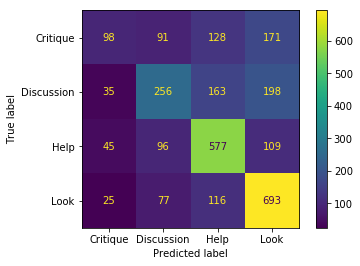

In [15]:

from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
        confusion_matrix(y_te_enc, bayes_final.predict(X_test_tfidf)),
        display_labels=LE.classes_,
        #cmap=plt.cm.Blues,
        #normalize=True,
    ).plot()
#disp.ax_.set_title("Confusion matrix")

#print(title)
#print(disp.confusion_matrix)

plt.show()


We can see that for Critique posts, misclassified posts are mostly identified as Look. 

Discussion posts that are misclassified tend to be misclassified as Look first, then as Help. 

Misclassified Help posts tend to be misclassified as Look and Discussion: 

Misclassified Look posts tend to be misclassified as Critique and Discussion. 

In order to identify if the issue with the misclassifications could stem from the way we regrouped the original flairs, we plot below how the original flairs are predicted: 

#### Classification vs original Flairs

In [16]:
crit_mask = y_te == "Critique"
disc_mask = y_te == "Discussion"
help_mask = y_te == "Help"
look_mask = y_te == "Look"

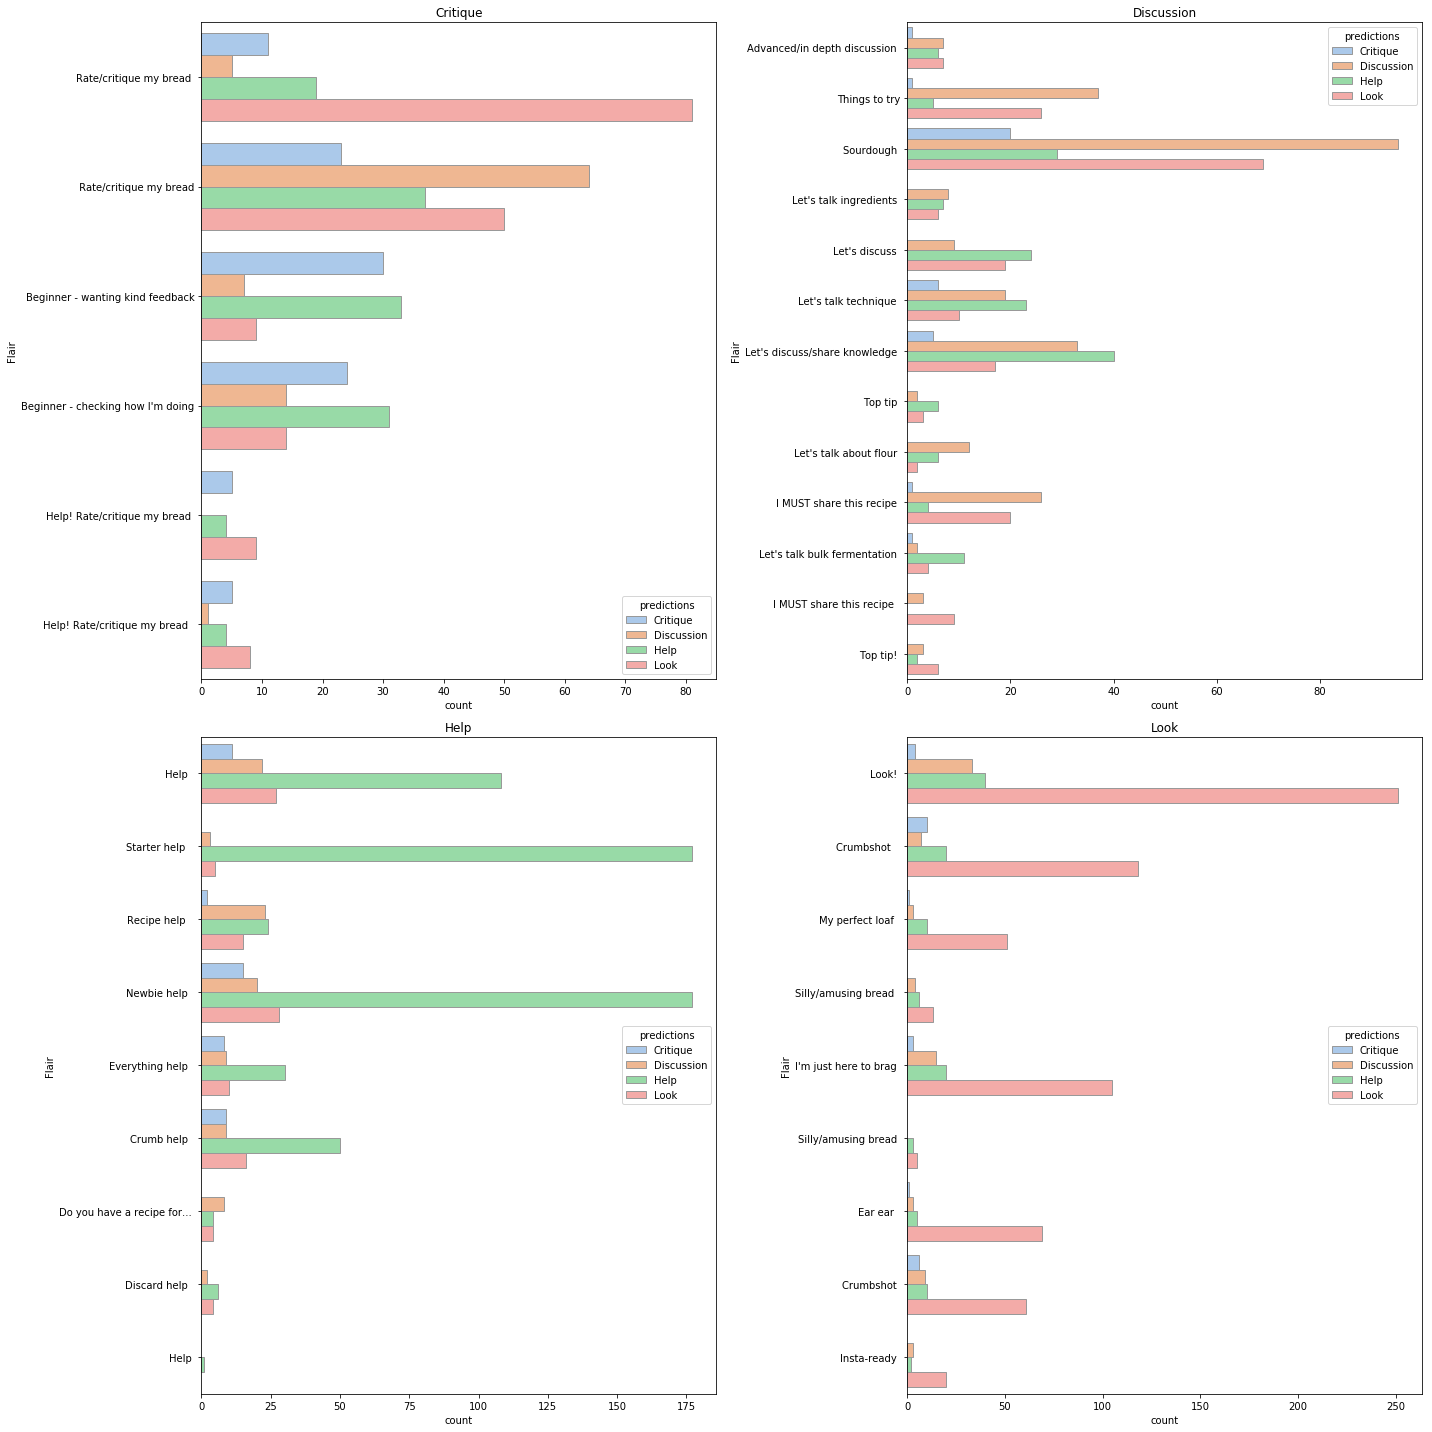

In [17]:
crit_df = test_df.loc[crit_mask, :].copy()
crit_df["predictions"] = LE.inverse_transform(bayes_final.predict(X_test_tfidf)[crit_mask])

disc_df = test_df.loc[disc_mask, :].copy()
disc_df["predictions"] = LE.inverse_transform(bayes_final.predict(X_test_tfidf)[disc_mask])

help_df = test_df.loc[help_mask, :].copy()
help_df["predictions"] = LE.inverse_transform(bayes_final.predict(X_test_tfidf)[help_mask])

look_df = test_df.loc[look_mask, :].copy()
look_df["predictions"] = LE.inverse_transform(bayes_final.predict(X_test_tfidf)[look_mask])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols=2, sharex = False, sharey = False,  figsize=(20,20))

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=crit_df, ax = ax1)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=disc_df, ax = ax2)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=help_df, ax = ax3)
plt.close(plt.gcf())

sns.catplot(y="Flair", hue="predictions", kind="count",
            palette="pastel", edgecolor=".6", hue_order = ["Critique", "Discussion", "Help", "Look"],
            data=look_df, ax = ax4)
plt.close(plt.gcf())

ax1.set_title("Critique")
ax2.set_title("Discussion")
ax3.set_title("Help")
ax4.set_title("Look")
plt.tight_layout()
plt.show()

We can see that for Posts in the Look category, it is very evident, that all original Flairs are majorly predicted as Look, as expected. The same goes for posts in the Help category, where a majority of the original flairs are predicted as Help, at the exception of the original flair "Do you have a recipe for...", where a majority tend to be predicted as Discussion. 

Regarding the other two categories, Critique and Discussion, the predictions are a bit messier. 

For Discussion, Some of the original flairs tend to be mainly predicted in the Help category: "Let's discuss", 'Let's discuss/share knowledge", "Let's talk bulk fermentation", "Let's talk technique" and "top tip". Even in Categories where the most frequent prediction is Discussion, the predictions are almost always split equaly with Look.   

Finally, for the Critique category, we can see that the two "Rate/critique my bread" have different distribution. 
For one of them, the majority of the posts are classified as Look instead of Critique, implying that the at some point the flair might have been used more as a way to show off photos of the bread. For the second "Rate/Critique my bread", all posts are almost equally distributed between all categories. Other than this observation, we can see that none of the original flairs were mainly predicted as Critique.  

Finally, we are interested in investigating which words were the most important for the classification task. 
For this, we display below the words with the highest probability in each class: 

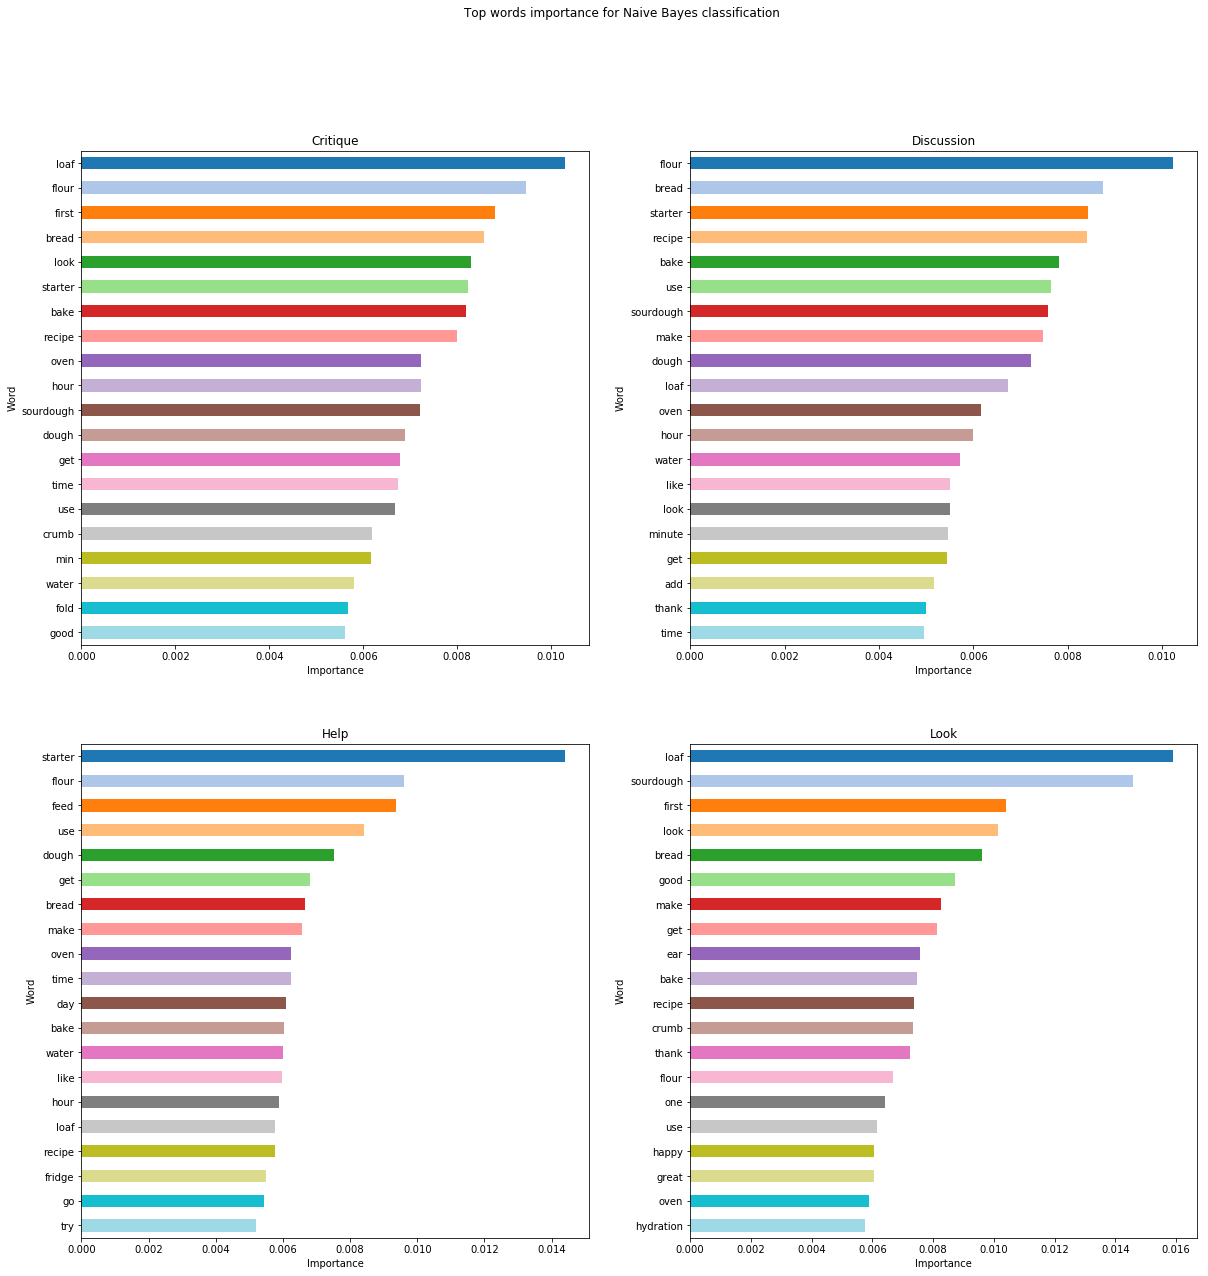

In [18]:
def get_top_words(words, importance, n):
#words = np.array(tf_idf.get_feature_names())
#importance = np.array(bayes_final.named_steps["bayes"].coef_[0])
    inds = importance.argsort()
    imp_words = words[inds][::-1]
    imp_value = np.exp(importance[inds][::-1])
    imp_df = pd.DataFrame({"Word" : imp_words, 
                       "imp" : imp_value
                      })
    return(imp_df.head(n))

fig, (axs) = plt.subplots(nrows = 2, ncols=2, sharex = False, sharey = False,  figsize=(20,20))
colormap = plt.cm.tab20(range(0, 20))
for x in range(4):
    if x == 0: 
        pos = axs[0,0]
    elif x ==1: 
        pos = axs[0,1]
    elif x ==2: 
        pos = axs[1,0]
    elif x ==3: 
        pos = axs[1,1]
    get_top_words(np.array(tf_idf.get_feature_names()), bayes_final.named_steps["bayes"].feature_log_prob_[x,:], 20).plot.barh(y = "imp", x = 'Word', color = colormap, legend = False, ax = pos)
    pos.set_title(LE.classes_[x])
    pos.set_xlabel('Importance')
    pos.set_ylabel('Word')
    pos.invert_yaxis()

fig.suptitle('Top words importance for Naive Bayes classification')
#plt.tight_layout()
plt.show()

The words with the highest probability for the Critique category are: loaf, flour, first, bread and look. 

The words with the highest probability for the Discussion category are: flour, bread, starter, recipe and bake. 

The words with the highest probability for the Help category are: starter, floor, feed, use and dough. 

The words with the highest probability for the Look category are: loaf, sourdough, first, look and bread. 

We can see that there is a lot of overlap between the words with the highest probabilities in each category. In particular, the fact the word with the highest probablity for Critique and Look is the same, can explain, why posts in Critique tended to be misclassified as Look. 

The words in the top 50 that are specific to each Flair are displayed below: 

In [19]:
top_critique = set(get_top_words(np.array(tf_idf.get_feature_names()), bayes_final.named_steps["bayes"].feature_log_prob_[0,:], 50).Word)
top_discussion = set(get_top_words(np.array(tf_idf.get_feature_names()), bayes_final.named_steps["bayes"].feature_log_prob_[1,:], 50).Word)
top_help = set(get_top_words(np.array(tf_idf.get_feature_names()), bayes_final.named_steps["bayes"].feature_log_prob_[2,:], 50).Word)
top_look = set(get_top_words(np.array(tf_idf.get_feature_names()), bayes_final.named_steps["bayes"].feature_log_prob_[3,:], 50).Word)

In [20]:
print("Top words with the highest probability in Critique, not in the top 20 words in the other categories: ", top_critique.difference(top_discussion ,top_help ,top_look))

print("Top words with the highest probability in Discussion, not in the top 20 words in the other categories: ", top_discussion.difference(top_critique ,top_help ,top_look))

print("Top words with the highest probability in Help, not in the top 20 words in the other categories: ", top_help.difference(top_discussion ,top_critique ,top_look))

print("Top words with the highest probability in Look, not in the top 20 words in the other categories: ", top_look.difference(top_discussion ,top_help ,top_critique))

Top words with the highest probability in Critique, not in the top 20 words in the other categories:  {'bit', 'rest'}
Top words with the highest probability in Discussion, not in the top 20 words in the other categories:  {'mix', 'let', 'remove'}
Top words with the highest probability in Help, not in the top 20 words in the other categories:  {'start', 'smell', 'discard', 'need', 'take', 'feed', 'help', 'put', 'keep'}
Top words with the highest probability in Look, not in the top 20 words in the other categories:  {'today', 'little', 'seed', 'attempt', 'delete', 'finally', 'pretty', 'turn', 'beautiful', 'happy', 'yet', 'love', 'amazing'}


The words that are only in the top 50 words for Critique are: rest and bit. 
The words that are only in the top 50 words for Discussion are: let and remove and mix. 
In both cases, theses words are describing processes in bread baking. The fact that there are not a lot of words that are specific to these categories, explains why this classifier is not a really good predictor for these classes. 

For Help, the words that only in the top 50 words for this flair are: need, put, help, take, discard, keep, smell, start and feed. Most of these words are linked to the feeding and maintenance of a starter. 

For Look, the words that are only in the top 50 words for this flair are : pretty, seed, today, little, love, turn, amazing, happy, beautiful, attempt finally, delete, yet. Most of these words are superlative or positive ways of expressing feedbacks on loaves.  
 

### 3) Saving model 

Next, we produce out of folds productions on the training set: 
* split the training setin 5 folds
* fit the model on the first 4 folds
* compute predictions on the last fold 
* repeat for all of the 5 folds

These predictions will be used for a quick data exploration of the prediction before computing the stacking classifier. We compute both: 
* the flair prediction, in order to have a quick access to them to compute the correlation between the classification errors of all 0-level models before stacking
* the probability predictions, to use in a PCA. 

In [21]:
oof_bayes_proba_pred = np.ndarray(shape = (0,4))
oof_bayes_class_pred = []
oof_bayes_true = []
for train_ix, test_ix in skf.split(X_train_tfidf, y_tr_enc):
    # get data
    train_X, test_X = X_train_tfidf[train_ix], X_train_tfidf[test_ix]
    train_y, test_y = y_tr_enc[train_ix], y_tr_enc[test_ix]
    # fit model
    bayes_final.fit(train_X, train_y)
    # store predictions
    oof_bayes_proba_pred = np.vstack((oof_bayes_proba_pred, bayes_final.predict_proba(test_X)))
    oof_bayes_class_pred.append(bayes_final.predict(test_X))
    oof_bayes_true.append(test_y)
oof_bayes_class_pred = np.concatenate(oof_bayes_class_pred).ravel()
oof_bayes_true = np.concatenate(oof_bayes_true).ravel()

In [22]:
# check resulting lists 
print(len(y_tr_enc))
print(oof_bayes_proba_pred.shape)
print(len(oof_bayes_class_pred))
print(len(oof_bayes_true))

6713
(6713, 4)
6713
6713


Finally, we save the models as well as the predictions into a pickle file 

In [23]:
# pickle model to disk
filename = 'results/01_bayes.sav'
pickle.dump([bayes_final, oof_bayes_proba_pred, oof_bayes_class_pred,  oof_bayes_true], open(filename, 'wb'))